# 🧠 Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you'll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [1]:
# Clone repo
not_cloned = False
if not_cloned:
    !git clone https://$token@github.com/gerkone/jku.wad.git
%cd jku.wad

C:\Users\Benjamin\Documents\GitHub\DRL_DOOM\jku.wad


In [2]:
# Install the dependencies
dependencies_not_installed = False
if dependencies_not_installed:
    !pip install torch numpy matplotlib vizdoom portpicker gym onnx

In [3]:
from typing import Dict, Sequence, Tuple
import os
import torch
from collections import deque, OrderedDict
import collections
from copy import deepcopy
import random
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from datetime import datetime
import time

from gym import Env
from torch import nn
from einops import rearrange

from doom_arena import VizdoomMPEnv
from doom_arena.reward import VizDoomReward
from doom_arena.render import render_episode
from IPython.display import HTML
from vizdoom import ScreenFormat

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y_%m_%d %H_%M_%S")

## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [5]:
USE_GRAYSCALE = True # ← flip to False for RGB

PLAYER_CONFIG = {
    "algo_type": "QVALUE",
    "n_stack_frames": 1,
    "extra_state": None,#["depth"],
    "hud": "none",
    "crosshair": True,
    "screen_format": 8 if USE_GRAYSCALE else 0
}

In [6]:
# TODO: environment training paramters
N_STACK_FRAMES = 1
NUM_BOTS = 4
EPISODE_TIMEOUT = 1100

#SCREEN_WIDTH = 120
#SCREEN_HEIGHT = 90
SCREEN_CHANNELS = 3 if not USE_GRAYSCALE else 1
#EXTRA_STATE = ["depth"]
HUD = "none"
CROSSHAIR = True
SCREEN_FORMAT = 8 if USE_GRAYSCALE else 0
#ACTION_SPACE = 7
#OBSERVATION_SPACE = (SCREEN_CHANNELS * N_STACK_FRAMES, SCREEN_HEIGHT, SCREEN_WIDTH)

# TODO: model hyperparams
GAMMA = 0.997
# EPISODES = 100
EPISODES = 1500
BATCH_SIZE = 128
REPLAY_BUFFER_SIZE = 500000
LEARNING_RATE = 2e-4
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.999
N_EPOCHS = 3

## Reward function
In this task, you will define a reward function to guide the agent's learning. The function is called at every step and receives the current and previous game variables (e.g., number of frags, hits taken, health).

Your goal is to combine these into a meaningful reward, encouraging desirable behavior, such as:

- Rewarding frags (enemy kills)

- Rewarding accuracy (hitting enemies)

- Penalizing damage taken

- (Optional) Encouraging survival, ammo efficiency, etc.

You can return multiple reward components, which are summed during training. Consider the class below as a great starting point!

In [7]:
# ---------------------------------------------------------------
# 🥇 reward function
# ---------------------------------------------------------------

class YourReward(VizDoomReward):
    def __init__(self, num_players: int):
        super().__init__(num_players)

    def __call__(
        self,
        vizdoom_reward: float,
        game_var: Dict[str, float],
        game_var_old: Dict[str, float],
        player_id: int,
    ) -> Tuple[float, ...]:
        """
        Custom reward function used by both training and evaluation.
        *  +100  for every new frag
        *  +2    for every hit landed
        *  -0.1  for every hit taken
        """
        self._step += 1
        _ = vizdoom_reward, player_id  # unused

        rwd_hit        =  1.2  * (game_var["HITCOUNT"]   - game_var_old["HITCOUNT"])
        rwd_hit_taken  = -0.05  * (game_var["HITS_TAKEN"] - game_var_old["HITS_TAKEN"]) #-0.1
        rwd_frag       = 8.0 * (game_var["FRAGCOUNT"]  - game_var_old["FRAGCOUNT"])
        if game_var["SELECTED_WEAPON_AMMO"]  - game_var_old["SELECTED_WEAPON_AMMO"] < 0 and np.allclose(rwd_hit, 0): #5
            #rwd_ammo = -0.03 * abs(game_var["SELECTED_WEAPON_AMMO"]  - game_var_old["SELECTED_WEAPON_AMMO"])
            rwd_ammo = -0.0003 * abs(game_var["SELECTED_WEAPON_AMMO"]  - game_var_old["SELECTED_WEAPON_AMMO"])
        else:
            rwd_ammo = 0

        rwd_movement = 0.0002 * np.sqrt((game_var["POSITION_X"] - game_var_old["POSITION_X"])**2 + (game_var["POSITION_Y"] - game_var_old["POSITION_Y"])**2) #0.002

        return rwd_hit, rwd_hit_taken, rwd_frag, rwd_movement, rwd_ammo


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
DTYPE = torch.float32

reward_fn = YourReward(num_players=1)

env = VizdoomMPEnv(
    num_players=1,
    num_bots=NUM_BOTS,
    bot_skill=0,
    doom_map="ROOM",  # NOTE simple, small map; other options: TRNM, TRNMBIG
    extra_state=PLAYER_CONFIG["extra_state"], # see info about states at the beginning of 'Environment configuration' above
    episode_timeout=EPISODE_TIMEOUT,
    n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
    crosshair=PLAYER_CONFIG["crosshair"],
    hud=PLAYER_CONFIG["hud"],
    reward_fn=reward_fn,
    screen_format=SCREEN_FORMAT,
    seed=1337
)

Host 59700
Player 59700


In [10]:
env_shape = env.reset()[0].size()
env_shape

torch.Size([1, 128, 128])

In [11]:
env.action_space.n

8

## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you’ll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [12]:
# ================================================================
# DQN — design your network here
# ================================================================
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual # The skip connection
        return F.relu(out)



class DQN(nn.Module):
    """
    Deep-Q Network template.

    Expected behaviour
    ------------------
    forward(frame)      # frame: (B, C, H, W)  →  Q-values: (B, num_actions)

    What to add / change
    --------------------
    • Replace the two `NotImplementedError` lines.
    • Build an encoder (Conv2d / Conv3d) + a head (MLP or duelling).
    • Feel free to use residual blocks from `agents/utils.py` or any design you like.
    """

    def __init__(self, input_dim: int, action_space: int, hidden: int = 128):
        super().__init__()

        # -------- TODO: define your layers ------------------------
        # Example (very small) baseline — delete or improve:
        #
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 32, 8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),       nn.ReLU(),
            ResidualBlock(64),
            nn.Conv2d(64, 128, 3, stride=1),       nn.ReLU(),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, hidden), nn.ReLU(),
            nn.Linear(hidden, action_space),
        )
        # -----------------------------------------------------------

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                #if m.bias is not None:
                #    nn.init.constant_(m.bias, 0)

    def forward(self, frame: torch.Tensor) -> torch.Tensor:
        # -------- TODO: implement forward -------------------------
        x = self.encoder(frame)
        x = self.head(x)
        return x
        # -----------------------------------------------------------


## Training Utils

In [13]:
# ---------------------------------------------------------------
# 🔧 stolen utils from dqn.py
# ---------------------------------------------------------------

@torch.no_grad
def epsilon_greedy(
    env: Env,
    model: nn.Module,
    obs: torch.Tensor,
    epsilon: float,
    device: torch.device,
    dtype: torch.dtype,
):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        obs = obs.to(device, dtype=dtype).unsqueeze(0)
        return model(obs).argmax().item()


@torch.no_grad()
def update_ema(ema_model, model, decay: float = 0.995):
    """Exponential moving average model updates."""
    ema_params = OrderedDict(ema_model.named_parameters())
    if hasattr(model, "module"):
        model_params = OrderedDict(model.module.named_parameters())
    else:
        model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)

epsilon = EPSILON_START

## Training

### Network Initialization

In [14]:
# ================================================================
# Initialise your networks and training utilities
# ================================================================
load = True
load_time = "2025_06_19 16_56_20"
# main Q-network
in_channels = env.observation_space.shape[0]   # 1 if grayscale, else 3/4
model = DQN(
    input_dim    = in_channels,
    action_space = env.action_space.n,
    hidden       = 128,   # change or ignore
).to(device, dtype=DTYPE)
if load:
    model.load_state_dict(torch.load(f"save_curr_model_{load_time}.pt"))
# TODO ------------------------------------------------------------
# 1. Create a target network (hard-copy or EMA)
# 2. Choose an optimiser + learning-rate schedule
# 3. Instantiate a replay buffer and set the initial epsilon value
#
# Hints:
#for m in model.encoder:
#    if hasattr(m, "bias"):
#        m.bias = None


model_tgt  = deepcopy(model).to(device)
# previosly trained with model_tgt parameters
optimizer  = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler  = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=GAMMA)
replay_buffer = collections.deque(maxlen=REPLAY_BUFFER_SIZE)
#replay_buffer = PrioritizedReplayBuffer(REPLAY_BUFFER_SIZE)

if load:
    optimizer.load_state_dict(torch.load(f"save_curr_optim_{load_time}.pt"))
    scheduler  = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=GAMMA)
    epsilon = 0.5

# ---------------------------------------------------------------


### Training Loop

In [15]:
# ---------------------  TRAINING LOOP  ----------------------
# Feel free to change EVERYTHING below:
#   • choose your own reward function
#   • track different episode statistics in `ep_metrics`
#   • switch optimiser, scheduler, update rules, etc.

reward_list, q_loss_list = [], []
individual_reward_dict = {
    "rwd_hit": [],
    "rwd_hit_taken": [],
    "rwd_frag": [],
    "rwd_movement": [],
    "rwd_ammo": [],
}

best_eval_return, best_model = float("-inf"), None

In [16]:
#model.to(device)

In [17]:
save_timestamp = get_timestamp()

for episode in range(EPISODES):
    episode_start_time = time.time()

    ep_metrics = {
        "custom_reward": 0.0,
        "rwd_hit": 0.0,
        "rwd_hit_taken": 0.0,
        "rwd_frag": 0.0,
        "rwd_movement": 0.0,
        "rwd_ammo": 0.0,
    }
    obs        = env.reset()[0]
    done, ep_return = False, 0.0
    model.eval()

    # ───────── rollout ─────────────────────────────────────────────
    while not done:
        act = epsilon_greedy(env, model, obs, epsilon, device, DTYPE)
        next_obs, rwd_raw, done, _ = env.step(act)

        # ----- reward definition (EDIT here) ----------------
        #custom_rwd = float(rwd_raw[0])      # default: raw env reward
        # Example: access game variables for more detailed reward engineering
        gv, gv_pre = env.envs[0].unwrapped._game_vars, env.envs[0].unwrapped._game_vars_pre
        rwds = reward_fn(rwd_raw[0], gv, gv_pre, player_id=0)
        rwd_hit, rwd_hit_taken, rwd_frag, rwd_movement, rwd_ammo = rwds
        custom_rwd = sum(rwds)

        ep_metrics["custom_reward"] += custom_rwd
        ep_metrics["rwd_hit"] += rwd_hit
        ep_metrics["rwd_hit_taken"] += rwd_hit_taken
        ep_metrics["rwd_frag"] += rwd_frag
        ep_metrics["rwd_movement"] += rwd_movement
        ep_metrics["rwd_ammo"] += rwd_ammo


        replay_buffer.append((obs, act, custom_rwd, next_obs[0], done))
        obs, ep_return = next_obs[0], ep_return + custom_rwd

    # Update reward tracking metrics
    reward_list.append(ep_return)
    individual_reward_dict["rwd_hit"].append(ep_metrics["rwd_hit"])
    individual_reward_dict["rwd_hit_taken"].append(ep_metrics["rwd_hit_taken"])
    individual_reward_dict["rwd_frag"].append(ep_metrics["rwd_frag"])
    individual_reward_dict["rwd_movement"].append(ep_metrics["rwd_movement"])
    individual_reward_dict["rwd_ammo"].append(ep_metrics["rwd_ammo"])


    # ───────── learning step (prioritized experience replay) ──────────────────
    if len(replay_buffer) >= BATCH_SIZE:
        model.train()
        for _ in range(N_EPOCHS):
            batch = random.sample(replay_buffer, BATCH_SIZE)
            s, a, r, s2, d = zip(*batch)

            s   = torch.stack(s).to(device, dtype=DTYPE)
            s2  = torch.stack(s2).to(device, dtype=DTYPE)
            a   = torch.tensor(a , device=device)
            r   = torch.tensor(r , device=device, dtype=torch.float32)
            d   = torch.tensor(d , device=device, dtype=torch.float32)

            q    = model(s).gather(1, a.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                q2 = model_tgt(s2).max(1).values
                tgt = r + GAMMA * q2 * (1 - d)

            # Calc TD Error for priority updates

            loss = F.mse_loss(q, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            q_loss_list.append(loss.item())
        update_ema(model_tgt, model)

    scheduler.step()
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)


    # ───────── quick evaluation for best-model tracking ───────────
    eval_obs, done, eval_return = env.reset()[0], False, 0.0
    model.eval()
    while not done:
        act = epsilon_greedy(env, model, eval_obs, 0.05, device, DTYPE)
        eval_obs_n, r, done, _ = env.step(act)

        # Use same custom reward for best model tracking
        gv, gv_pre = env.envs[0].unwrapped._game_vars, env.envs[0].unwrapped._game_vars_pre
        eval_custom_rwd = sum(reward_fn(r[0], gv, gv_pre, player_id=0))

        eval_obs = eval_obs_n[0]
        #eval_return += r[0]
        eval_return += eval_custom_rwd
    if eval_return > best_eval_return:
        best_eval_return, best_model = eval_return, deepcopy(model)


    if episode%100 == 0:
        torch.save(model.state_dict(), f"save_curr_model_{save_timestamp}_episode_{episode:04d}.pt")
        torch.save(optimizer.state_dict(), f"save_curr_optim_{save_timestamp}_episode_{episode:04d}.pt")
        torch.save(scheduler.state_dict(), f"save_curr_scheduler_{save_timestamp}_episode_{episode:04d}.pt")

    episode_end_time = time.time()

    print(f"Ep {episode+1:03}: return {ep_return:6.1f}  |  ε {epsilon:.3f}  |  ep time: {episode_end_time-episode_start_time:05.2f}")
# ---------------------  SAVE / EXPORT ---------------------------------------
final_model = best_model if best_model is not None else model          # choose best


Ep 001: return    0.0  |  ε 0.999  |  ep time: 15.73
Ep 002: return   -0.1  |  ε 0.998  |  ep time: 15.55
Ep 003: return    0.1  |  ε 0.997  |  ep time: 14.49
Ep 004: return    0.0  |  ε 0.996  |  ep time: 14.44
Ep 005: return    0.0  |  ε 0.995  |  ep time: 14.82
Ep 006: return   -1.0  |  ε 0.994  |  ep time: 14.40
Ep 007: return   -0.4  |  ε 0.993  |  ep time: 14.86
Ep 008: return    0.0  |  ε 0.992  |  ep time: 14.38
Ep 009: return   -0.3  |  ε 0.991  |  ep time: 14.68
Ep 010: return    0.0  |  ε 0.990  |  ep time: 14.65
Ep 011: return    0.5  |  ε 0.989  |  ep time: 15.99
Ep 012: return   -0.1  |  ε 0.988  |  ep time: 15.15
Ep 013: return    0.0  |  ε 0.987  |  ep time: 15.36
Ep 014: return    0.0  |  ε 0.986  |  ep time: 15.07
Ep 015: return   -0.4  |  ε 0.985  |  ep time: 15.38
Ep 016: return   -0.9  |  ε 0.984  |  ep time: 15.17
Ep 017: return   -0.7  |  ε 0.983  |  ep time: 15.45
Ep 018: return   -0.9  |  ε 0.982  |  ep time: 15.47
Ep 019: return   -0.6  |  ε 0.981  |  ep time:

KeyboardInterrupt: 

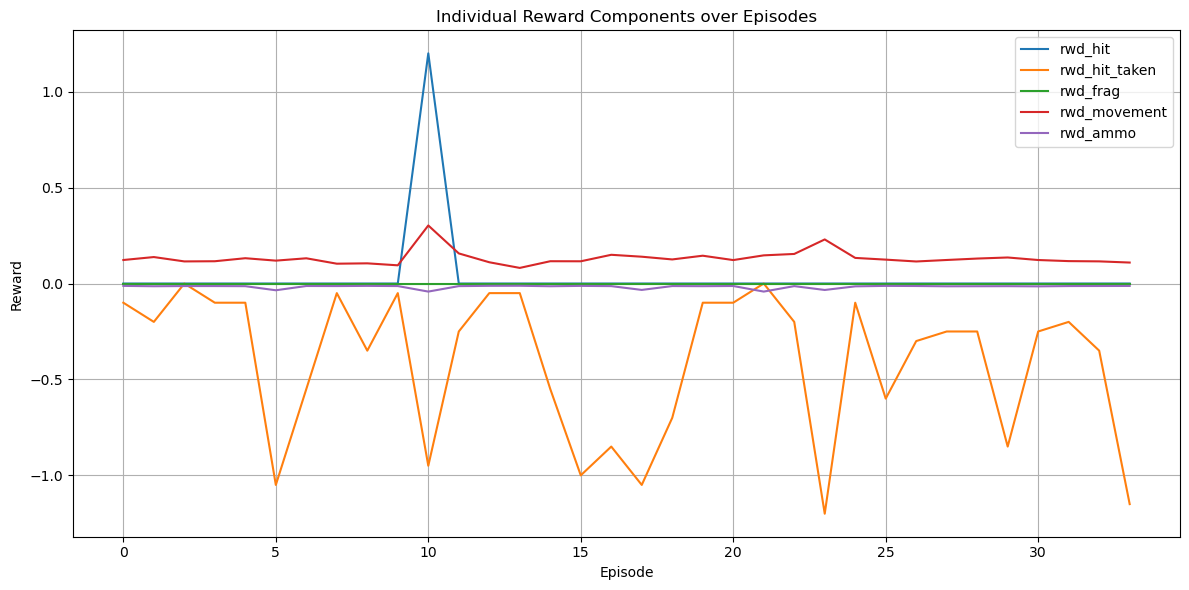

In [18]:
def plot_individual_rewards(reward_dict, title, smooth_window=5):
    df = pd.DataFrame(reward_dict)
    df_smooth = df.rolling(window=smooth_window, min_periods=1).mean()

    # Plot raw and smoothed values
    plt.figure(figsize=(12, 6))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.tight_layout()
    plt.show()


plot_individual_rewards(individual_reward_dict, "Individual Reward Components over Episodes")

In [19]:
# ---------------------  SAVE / EXPORT ---------------------------------------
final_model = best_model if best_model is not None else model


In [20]:
save_timestamp = get_timestamp()
torch.save(model.state_dict(), f"save_curr_model_{save_timestamp}.pt")
torch.save(optimizer.state_dict(), f"save_curr_optim_{save_timestamp}.pt")
print("Saved to: " + f"save_curr_model_{save_timestamp}.pt" + " - " + f"save_curr_optim_{save_timestamp}.pt")

Saved to: save_curr_model_2025_06_19 16_56_20.pt - save_curr_optim_2025_06_19 16_56_20.pt


In [21]:
torch.save(final_model.state_dict(), f"save_best_model_{save_timestamp}.pt")
print("Saved to: " + f"save_best_model_{save_timestamp}.pt")

Saved to: save_best_model_2025_06_19 16_56_20.pt


In [22]:
# Path to the log file
log_file = f"reward_log_{save_timestamp}.txt"

# Function to log rewards to a file
def log_rewards_to_file(individual_reward_dict, log_file):
    """
    Writes the individual reward components and total rewards to a log file.

    Parameters:
    ----------
    individual_reward_dict : dict
        A dictionary containing lists of individual rewards for each episode.
    total_rewards : list
        A list of total rewards for each episode.
    log_file : str
        The filename where the reward data will be logged.
    """
    with open(log_file, "w") as f:
        # Write header
        header = "Episode,rwd_hit,rwd_hit_taken,rwd_frag,rwd_movement,rwd_ammo,Total_Reward\n"
        f.write(header)

        # Write each episode's data
        for episode in range(len(individual_reward_dict['rwd_hit'])):
            line = f"{episode + 1:4d}," \
                   f"{individual_reward_dict['rwd_hit'][episode]:7.3f}," \
                   f"{individual_reward_dict['rwd_hit_taken'][episode]:7.3f}," \
                   f"{individual_reward_dict['rwd_frag'][episode]:7.3f}," \
                   f"{individual_reward_dict['rwd_movement'][episode]:7.3f}," \
                   f"{individual_reward_dict['rwd_ammo'][episode]:7.3f}," \
                   f"{individual_reward_dict['rwd_hit'][episode] + individual_reward_dict['rwd_hit_taken'][episode] + individual_reward_dict['rwd_frag'][episode] + individual_reward_dict['rwd_movement'][episode] + individual_reward_dict['rwd_ammo'][episode]:7.3f}\n"
            f.write(line)

    print(f"Rewards successfully logged to {log_file}.")

# Example usage
log_rewards_to_file(individual_reward_dict, log_file)

Rewards successfully logged to reward_log_2025_06_19 16_56_20.txt.


## Dump to ONNX

In [16]:
# ---------------------------------------------------------------
# 🧭 model save
# ---------------------------------------------------------------

import onnx
import json


def onnx_dump(env, model, config, filename: str):
    # dummy state
    init_state = env.reset()[0].unsqueeze(0)


    # Export to ONNX
    torch.onnx.export(
        model.cpu(),
        args=init_state,
        f=filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    onnx_model = onnx.load(filename)

    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)

In [18]:
#curr_time = get_timestamp()
curr_time = save_timestamp
onnx_dump(env, model, PLAYER_CONFIG, filename=f"model_{curr_time}.onnx")
onnx_dump(env, final_model, PLAYER_CONFIG, filename=f"final_model_{curr_time}.onnx")
print(f"Best network exported to model_{curr_time}.onnx")

Best network exported to model_2025_06_19 17_02_42.onnx


### Evaluation and Visualization

In this final section, you can evaluate your trained agent, inspect its performance visually, and analyze reward components over time.


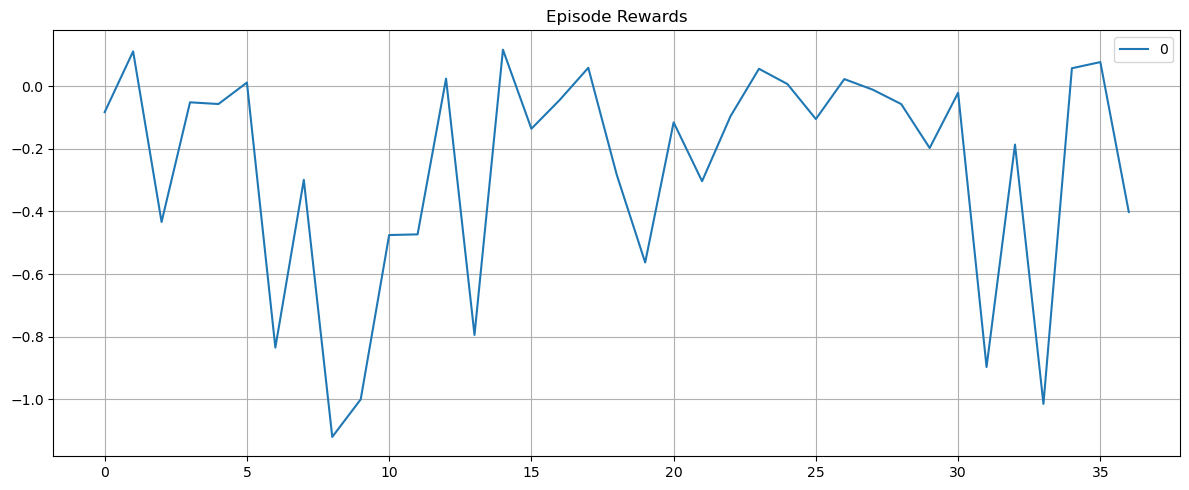

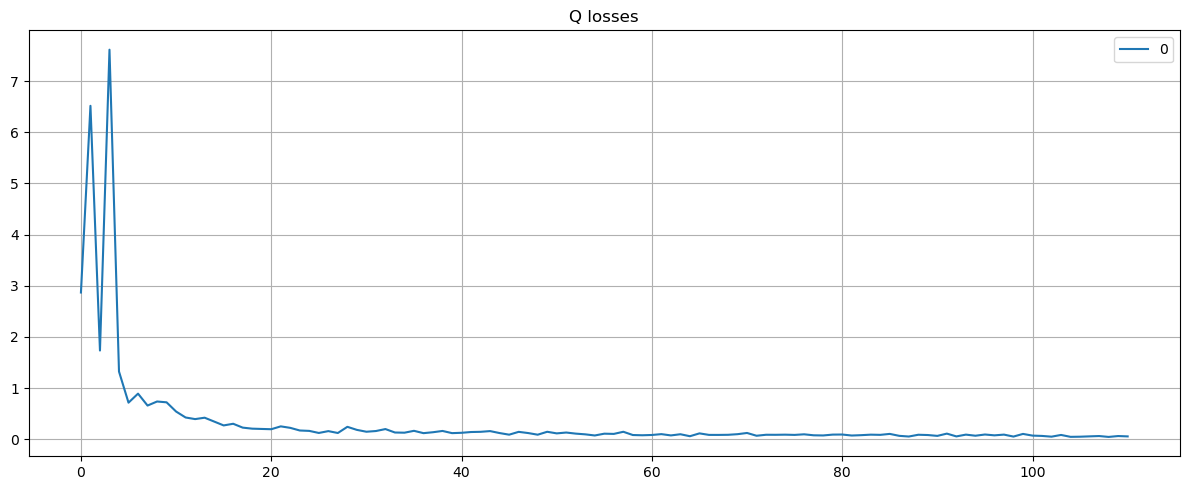

In [27]:
# ---------------------------------------------------------------
# 📈  Reward-plot helper  (feel free to edit / extend)
# ---------------------------------------------------------------
test_plot = {"loss": [1, 2, 3], "jakie": [4, 5, 6]}

import pandas as pd
import matplotlib.pyplot as plt

def plot_reward_components(reward_log, title, smooth_window: int = 5):
    """
    Plot raw and smoothed episode-level reward components.

    Parameters
    ----------
    reward_log : list[dict]
        Append a dict for each episode, e.g. {"frag": …, "hit": …, "hittaken": …}
    smooth_window : int
        Rolling-mean window size for the smoothed curve.
    """
    if not reward_log:
        print("reward_log is empty – nothing to plot.")
        return

    df = pd.DataFrame(reward_log)
    df_smooth = df.rolling(window=smooth_window, min_periods=1).mean()

    # raw
    plt.figure(figsize=(12, 5))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.title(title)
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # smoothed
    #plt.figure(figsize=(12, 5))
    #for col in df.columns:
    #    plt.plot(df.index, df_smooth[col], label=f"{col} (avg)")
    #plt.title(f"Smoothed (window={smooth_window})")
    #plt.legend(); plt.grid(True); plt.tight_layout()
    #plt.show()

plot_reward_components(reward_list, "Episode Rewards")
plot_reward_components(q_loss_list, "Q losses")

In [31]:
# ---------------------------------------------------------------
# 🔴 test and record video
# ---------------------------------------------------------------
import onnx
import onnxruntime
import gymnasium as gym
import numpy as np
import imageio.v2 as imageio
from doom_arena.render import render_episode
from IPython.display import HTML
from vizdoom import ScreenFormat
import torch

#model_time = "2025_06_14 11_07_40"
#model_time = "2025_06_18 01_24_58"
model_time = curr_time
#model_time = "2025_06_17 12_25_43"
model_path = f"final_model_{model_time}.onnx"
#model_path = f"model_without_bias_{model_time}.onnx"
onnx_model = onnx.load(model_path)
session = onnxruntime.InferenceSession(model_path)

def preprocess(state):
    if isinstance(state, torch.Tensor):
        state = state.numpy()
    return np.expand_dims(state, axis=0).astype(np.float32)


def select_action(state):
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    action_values = session.run([output_name], {input_name: state})[0]
    return np.argmax(action_values)


#eval_env = VizdoomMPEnv(
#    num_players=1,
#    num_bots=NUM_BOTS,
#    bot_skill=0,
#    doom_map="ROOM",
#    extra_state=PLAYER_CONFIG["extra_state"],
#    episode_timeout=EPISODE_TIMEOUT,
#    n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
#    crosshair=PLAYER_CONFIG["crosshair"],
#    hud=PLAYER_CONFIG["hud"]
#)

eval_env = VizdoomMPEnv(
    num_players=1,
    num_bots=NUM_BOTS,
    bot_skill=0,
    doom_map="ROOM",  # NOTE simple, small map; other options: TRNM, TRNMBIG
    extra_state=PLAYER_CONFIG["extra_state"], # see info about states at the beginning of 'Environment configuration' above
    episode_timeout=EPISODE_TIMEOUT,
    n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
    crosshair=PLAYER_CONFIG["crosshair"],
    hud=PLAYER_CONFIG["hud"],
    screen_format=SCREEN_FORMAT,
    seed=1337
)

eval_env.enable_replay()

reset_result = eval_env.reset()
if isinstance(reset_result, tuple) and len(reset_result) == 2:
    state, info = reset_result
else:
    state = reset_result
    info = None

state = state[0]

total_reward = 0
done = False

while not done:
    processed_state = preprocess(state)

    action = select_action(processed_state)


    next_state_list, reward_list, done, info = eval_env.step(action)

    next_state = next_state_list[0]
    reward = reward_list[0]

    total_reward += reward
    state = next_state


eval_env.disable_replay()

replays = eval_env.get_player_replays()

frames_from_replay = []
if replays:
    for player_id, player_replay in replays.items():
        print(f"Processing replay for player {player_id}")
        for frame_data in player_replay.get('frames', []):
            if isinstance(frame_data, dict):
                screen_buffer = frame_data.get('screen')
            elif isinstance(frame_data, np.ndarray):
                screen_buffer = frame_data
            else:
                print(f"Skipping unexpected data type in replay list: {type(frame_data)}")
                continue

            if screen_buffer is not None:
                frame_to_save = None
                if PLAYER_CONFIG["screen_format"] == 0:
                     if screen_buffer.shape[0] in [3, 4]:
                         frame_to_save = np.transpose(screen_buffer[:3, :, :], (1, 2, 0))
                     else:
                         print(f"Warning: Unexpected shape for CRCGCB format: {screen_buffer.shape}. Skipping frame.")
                         continue
                elif PLAYER_CONFIG["screen_format"] == 8:
                     if screen_buffer.shape[0] == 1:
                         frame_to_save = np.squeeze(screen_buffer, axis=0)
                     else:
                         print(f"Warning: Unexpected shape for GRAY8 format: {screen_buffer.shape}. Skipping frame.")
                         continue
                else:
                     print(f"Warning: Unhandled screen format {PLAYER_CONFIG['screen_format']}. Skipping frame.")
                     continue

                if frame_to_save is not None:
                    if frame_to_save.dtype != np.uint8:
                         if np.max(frame_to_save) <= 1.0:
                             frame_to_save = (frame_to_save * 255).astype(np.uint8)
                         else:
                             frame_to_save = frame_to_save.astype(np.uint8)
                    frames_from_replay.append(frame_to_save)

else:
    print("No replay data was recorded.")



video_path = f"doom_play_{model_time}.mp4"
if os.path.exists(video_path):
    str_addon = datetime.now().strftime("%M_%S")
    video_path = f"doom_play_{model_time}__{str_addon}.mp4"

if frames_from_replay:
    fps = eval_env.metadata.get('render_fps', 35)
    try:
        with imageio.get_writer(video_path, fps=fps, format='FFMPEG', mode='I') as writer:
             for frame in frames_from_replay:
                 writer.append_data(frame)
        print(f"Video saved to {video_path}")
    except Exception as e:
        print(f"Error saving video: {e}")
        print("Ensure FFMPEG is installed on your system and imageio can find it.")
else:
    print("No frames extracted from replay for video.")


print(f"Episode finished. Total reward: {total_reward}")

eval_env.close()

Host 58733
Player 58733
Enabling replays!
Disabling replays!
Processing replay for player WhoAmI
No frames extracted from replay for video.
Episode finished. Total reward: -1.3


In [19]:
# ---------------------------------------------------------------
# ▶ play video
# ---------------------------------------------------------------

from IPython.display import HTML
import base64

video_path = f"doom_play_{model_time}.mp4"

# Read the video file as bytes
with open(video_path, "rb") as video_file:
    video_bytes = video_file.read()

# Encode the video bytes in base64
video_base64 = base64.b64encode(video_bytes).decode()

# Create the HTML video tag with the base64 encoded data
video_html = f"""
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
"""

# Display the HTML
display(HTML(video_html))

In [90]:
optimizer.state_dict()

{'state': {0: {'step': tensor(1360.),
   'exp_avg': tensor([[[[-3.7760e-04, -3.1757e-04, -3.4318e-04,  ..., -4.0904e-04,
              -3.9137e-04, -3.7096e-04],
             [-3.7576e-04, -3.6510e-04, -4.0542e-04,  ..., -3.5865e-04,
              -4.1020e-04, -3.8988e-04],
             [-3.9373e-04, -4.0589e-04, -4.2401e-04,  ..., -3.9506e-04,
              -3.9094e-04, -4.3721e-04],
             ...,
             [-3.4091e-04, -4.5878e-04, -4.1763e-04,  ..., -3.4655e-04,
              -4.4741e-04, -4.3242e-04],
             [-4.4782e-04, -4.6806e-04, -4.5596e-04,  ..., -4.6129e-04,
              -4.5152e-04, -5.3256e-04],
             [-4.4955e-04, -4.5062e-04, -4.5408e-04,  ..., -4.6572e-04,
              -4.6200e-04, -4.9501e-04]],
   
            [[-3.4482e-04, -3.1050e-04, -3.1051e-04,  ..., -3.6725e-04,
              -3.4315e-04, -3.8210e-04],
             [-3.3762e-04, -3.5652e-04, -3.5536e-04,  ..., -3.2618e-04,
              -3.6725e-04, -3.6567e-04],
             [-3.4414e-0

In [91]:
new_optim = deepcopy(optimizer)

In [93]:
new_optim.param_groups[0]['lr'] = 3e-4
new_optim.state_dict()

{'state': {0: {'step': tensor(1360.),
   'exp_avg': tensor([[[[-3.7760e-04, -3.1757e-04, -3.4318e-04,  ..., -4.0904e-04,
              -3.9137e-04, -3.7096e-04],
             [-3.7576e-04, -3.6510e-04, -4.0542e-04,  ..., -3.5865e-04,
              -4.1020e-04, -3.8988e-04],
             [-3.9373e-04, -4.0589e-04, -4.2401e-04,  ..., -3.9506e-04,
              -3.9094e-04, -4.3721e-04],
             ...,
             [-3.4091e-04, -4.5878e-04, -4.1763e-04,  ..., -3.4655e-04,
              -4.4741e-04, -4.3242e-04],
             [-4.4782e-04, -4.6806e-04, -4.5596e-04,  ..., -4.6129e-04,
              -4.5152e-04, -5.3256e-04],
             [-4.4955e-04, -4.5062e-04, -4.5408e-04,  ..., -4.6572e-04,
              -4.6200e-04, -4.9501e-04]],
   
            [[-3.4482e-04, -3.1050e-04, -3.1051e-04,  ..., -3.6725e-04,
              -3.4315e-04, -3.8210e-04],
             [-3.3762e-04, -3.5652e-04, -3.5536e-04,  ..., -3.2618e-04,
              -3.6725e-04, -3.6567e-04],
             [-3.4414e-0

In [94]:
torch.save(new_optim.state_dict(), f"save_curr_optim_with_initial_lr_{save_timestamp}.pt")

## Correct Save Utility

In [30]:
def restore_model(timestamp):
    model = DQN(
        input_dim=in_channels,
        action_space=env.action_space.n,
        hidden=64,  # change or ignore
    ).to(device, dtype=DTYPE)
    model.load_state_dict(torch.load(f"save_best_model_{timestamp}.pt"))
    for m in model.encoder:
        if hasattr(m, "bias"):
            m.bias = None
    onnx_dump(env, model, PLAYER_CONFIG, filename=f"model_without_bias_{timestamp}.onnx")


restore_model("2025_06_19 14_34_09")